In [19]:
import os
from openimages.download import download_dataset

In [1]:
data_dirs = ["val", "train", "test"]
number_for_samples = 200
classes = ["Flower", "Dog", "Cat"]
classes_dict = {"flower": 0, "dog": 1, "cat": 2}

In [45]:
for data_dir in data_dirs:
    if not os.path.exists(data_dir):
        os.makedirs(data_dir)

In [46]:
print("Downloading is starting...")

download_dataset("train", classes, limit=3000, annotation_format="pascal")
# download_dataset("val", classes, limit=200, annotation_format="pascal")
download_dataset("test", classes, limit=200, annotation_format="pascal")

2023-04-25  00:17:08 INFO Downloading 3000 train images for class 'flower'
100%|███████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [01:58<00:00, 25.31it/s]
2023-04-25  00:19:07 INFO Creating 3000 train annotations (pascal) for class 'flower'
100%|█████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:01<00:00, 2795.02it/s]
2023-04-25  00:19:09 INFO Downloading 2549 train images for class 'dog'
100%|███████████████████████████████████████████████████████████████████████████████████████| 2549/2549 [01:41<00:00, 25.18it/s]
2023-04-25  00:20:50 INFO Creating 2549 train annotations (pascal) for class 'dog'
100%|█████████████████████████████████████████████████████████████████████████████████████| 2549/2549 [00:00<00:00, 5365.11it/s]
2023-04-25  00:20:52 INFO Downloading 3000 train images for class 'cat'
100%|███████████████████████████████████████████████████████████████████████████████████████| 30

{'flower': {'images_dir': 'test/flower/images',
  'annotations_dir': 'test/flower/pascal'},
 'dog': {'images_dir': 'test/dog/images',
  'annotations_dir': 'test/dog/pascal'},
 'cat': {'images_dir': 'test/cat/images',
  'annotations_dir': 'test/cat/pascal'}}

In [2]:
import sys
sys.path.append('/Users/mantasbagdonas/miniconda3/lib/python3.10/site-packages')

In [2]:
import sys
print(sys.executable)

/Users/mantasbagdonas/miniconda3/envs/torch/bin/python


In [7]:
import torch
import torchvision
from torch.autograd import Variable
from torchvision import datasets
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torch.optim as optim
import numpy as np
from skimage import io
from skimage.transform import resize
from skimage.color import gray2rgb
import glob
import PIL
from PIL import Image
import matplotlib.pyplot as plt
from torch.autograd import Variable
from torchvision import models
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.tensorboard import SummaryWriter
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [8]:
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.Resize(256),
    transforms.RandomResizedCrop(224),
    transforms.ToTensor(),                     
    transforms.Normalize(                      
    mean=[0.5, 0.5, 0.5],                
    std=[0.5, 0.5, 0.5]                  
    )])

transform_viz = transforms.Compose([           
    transforms.ToTensor(),                     
    ])

In [9]:
def read_img(file_name, train=True, add_dim=False):
    img = Image.open(file_name).convert("RGB")
    if train:
        img_t = transform_train(img)
    else:
        img_t = transform_viz(img)
    if add_dim:
        img_t = torch.unsqueeze(img_t, 0)
    return img_t

In [12]:
import glob2
import xml.etree.ElementTree as ET
import numpy as np
import torch
import torch.nn.functional as F

In [13]:
def load_meta_data(folder):
    return glob2.glob("{}/*/pascal/*xml".format(folder))

In [14]:
def get_values(data, indexes, class_min):
    return [data[index] for index in indexes[0:class_min]]

def get_data(folder, class_counts = {'a': 1600, 'b': 1600, 'c': 1600}):
    meta_data_files = load_meta_data(folder)
    files = []
    values = []

    for i, meta_file in enumerate(meta_data_files):
        tree = ET.parse(meta_file)
        root = tree.getroot()
        file_path = root.find('path').text

        if len(root.findall('object')) == 1:
            obj = root.findall('object')[0]
            label = obj.find('name').text
            values.append(classes_dict[label])
            files.append(file_path)
            
    first_class = [i for i, x in enumerate(values) if x == 0]
    second_class = [i for i, x in enumerate(values) if x == 1]
    third_class = [i for i, x in enumerate(values) if x == 2]
    X_balanced = get_values(files, first_class, class_counts['a']) + get_values(files, second_class, class_counts['b']) + get_values(files, third_class, class_counts['c'])
    
    Y_balanced = get_values(values, first_class, class_counts['a']) + get_values(values, second_class, class_counts['b']) + get_values(values, third_class, class_counts['c'])
    
    return X_balanced, Y_balanced


In [287]:
counts_single = {'a': 300, 'b': 900, 'c': 700}
counts_multi = {'a': 500, 'b': 950, 'c': 950}

X_train_s, Y_train_s = get_data('train', counts_single)
X_train_m, Y_train_m = get_data('train', counts_multi)

X_val, Y_val = get_data('val', {'a': 104, 'b': 104, 'c': 104})
X_test, y_test = get_data('test', {'a': 104, 'b': 104, 'c': 104})

In [288]:
class_counts = np.bincount(np.array(Y_train_s))

# Print the class counts
for i, count in enumerate(class_counts):
    print("Class {}: Count = {}".format(i, count))

Class 0: Count = 300
Class 1: Count = 900
Class 2: Count = 700


In [289]:
class MultiTaskDataset(Dataset):
    def __init__(self, files, y):
        self.y = y
        self.files = files

    def __len__(self): return len(self.files)

    def __getitem__(self, index):
        image_file = self.files[index]
        img = read_img(image_file)
        
        y = self.y[index]
        
        return img, (y)

In [290]:
Y_train_s = torch.tensor(Y_train_s)
Y_train_s = F.one_hot(Y_train_s, num_classes=3)

traindataset = MultiTaskDataset(X_train_s, Y_train_s)

trainloader = torch.utils.data.DataLoader(traindataset, batch_size=8, shuffle=True)

In [291]:
Y_train_m = torch.tensor(Y_train_m)
Y_train_m = F.one_hot(Y_train_m, num_classes=3)

traindataset_m = MultiTaskDataset(X_train_m, Y_train_m)

trainloader_m = torch.utils.data.DataLoader(traindataset_m, batch_size=8, shuffle=True)

In [292]:
mps_available = hasattr(torch.backends, "mps") and torch.backends.mps.is_available()
device = torch.device("mps" if mps_available else "cpu")
device

device(type='mps')

## Joining into a multitask model

In [293]:
class MultiTaskModel(nn.Module):
    def __init__(self):
        super(MultiTaskModel, self).__init__()
        self.model = models.resnet18(pretrained=True)
        
        self.features = nn.Sequential(*list(self.model.children())[:-1])
        
        self.model.fc_single = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 3))
        
        self.model.fc_multi = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 3))
        
        for param in self.model.parameters():
            param.requires_grad = False

        for param in self.model.fc_single.parameters():
            param.requires_grad = True
        for param in self.model.fc_multi.parameters():
            param.requires_grad = True
        
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        
        y1 = self.model.fc_single(x)
        y2 = self.model.fc_multi(x)
        
        return torch.softmax(y1, dim=1), torch.sigmoid(y2)
    
    def update_grad(self, single_grad=True, multi_grad=True):
        for param in self.model.fc_single.parameters():
            param.requires_grad = single_grad
        for param in self.model.fc_multi.parameters():
            param.requires_grad = multi_grad
        
    def print_parameters(self):
        for name, param in self.model.named_parameters():
            if 'fc_single' in name or 'fc_multi' in name:
                print(name, param)
                
    def load_weights(self, weights):
        self.model.load_state_dict(weights)

In [311]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import time

multi_label_threshold = 0.4

def evaluate_standalone(model, X_test=X_test, y_test=y_test):
    preds_single = []
    for (i, path) in enumerate(X_test):
        img = read_img(path, False, True)
        img = img.to(device)
        with torch.inference_mode():
            predict = model(img)
            preds_single.append(np.argmax(predict[0].detach().tolist()))
            
    print(classification_report(y_test, preds_single, target_names=classes))

def make_multitask_predictions(model, X_test=X_test, y_test=y_test):
    preds_single = []
    preds_multi = []
    for (i, path) in enumerate(X_test):
        img = read_img(path, False, True)
        img = img.to(device)
        with torch.inference_mode():
            predict = model(img)
            preds_single.append(np.argmax(predict[0].detach().tolist()))
            temp_m= predict[1].detach().cpu().numpy()
            temp_m = (temp_m > multi_label_threshold).astype(int).tolist()
            preds_multi.append(temp_m[0])
        
    return preds_single, preds_multi

def evaluate_and_print_progress(model, loss, epoch, duration=0):
    pred_s, pred_m = make_multitask_predictions(model)
    y_true_m = torch.tensor(y_test)
    y_true_m = F.one_hot(y_true_m, num_classes=3)
        
    accuracy_s = accuracy_score(y_test, pred_s)
    accuracy_m = accuracy_score(y_true_m, pred_m)

    print('[epoch %d]: loss: %.3f, single acc: %.3f, multi acc: %.3f, duration: %ds' %
          (epoch + 1, loss, accuracy_s, accuracy_m, duration))
    
    return (accuracy_s, accuracy_m)


def evaluate_model(model, X_test=X_test, y_test=y_test):
    preds_single, preds_multi = make_multitask_predictions(model, X_test, y_test)
    
    y_true_m = torch.tensor(y_test)
    y_true_m = F.one_hot(y_true_m, num_classes=3)
        
    accuracy_s = accuracy_score(y_test, preds_single)
    accuracy_m = accuracy_score(y_true_m, preds_multi)
    
    print("Single-label accuracy: ", accuracy_s)
    print(classification_report(y_test, preds_single, target_names=classes))
    print()
    print("Multi-label accuracy: ", accuracy_m)
    print(classification_report(y_true_m, preds_multi, target_names=classes))
    
    return (accuracy_s, accuracy_m)
    
    
def optimize_task(model, loader, optimizer, loss_fn, task, epoch):
    running_loss = 0.0
    i = 0
    for i, (inputs, labels) in enumerate(loader, 0):
        inputs = inputs.to(device)
        labels = labels.to(device)
        labels = labels.type(torch.float32)

        optimizer.zero_grad()

        pred_s, pred_m = model(inputs)
        if task == "single": 
            loss = loss_fn(pred_s, labels)
        else:
            loss = loss_fn(pred_m, labels)
            
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        i += 1
    
    return running_loss / i
    
def train_single_label(model, epochs = 10):    
    single_losses = []
    accs = []
    model.train()
    for epoch in range(epochs):
        start = time.time()
        
        model.update_grad(single_grad=True, multi_grad=False)
        loss = optimize_task(model, trainloader, optimizer_single, criterion_single, "single", epoch)
                
        end = time.time()
            
        model.eval()
        acc = evaluate_and_print_progress(model, loss, epoch, end - start)
        model.train()
        
        accs.append(acc)
        single_losses.append(loss)
                
    return single_losses, accs

def train_multi_label(model, epochs = 10):    
    multi_losses = []
    accs = []
    model.train()
    for epoch in range(epochs):
        start = time.time()

        model.update_grad(single_grad=False, multi_grad=True)
        loss = optimize_task(model, trainloader_m, optimizer_multi, criterion_multi, "multi", epoch)
        
        end = time.time()
        
        model.eval()
        acc = evaluate_and_print_progress(model, loss, epoch, end - start)
        model.train()
        
        accs.append(acc)
        multi_losses.append(loss)
                
    return multi_losses, accs

In [264]:
model_mt = MultiTaskModel().to(device)
optimizer_single = optim.Adam(filter(lambda p: p.requires_grad, model_mt.parameters()), lr=0.002)
optimizer_multi = optim.Adam(filter(lambda p: p.requires_grad, model_mt.parameters()), lr=0.001)

criterion_multi = nn.BCEWithLogitsLoss().to(device)
criterion_single = nn.CrossEntropyLoss().to(device)

/Users/mantasbagdonas/miniconda3/envs/torch/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/mantasbagdonas/miniconda3/envs/torch/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [265]:
#train multi label
losses_m, multi_losses, accs_m = train_multi_label(model_mt, 10)

[epoch 1]: loss: 0.691, single acc: 0.359, multi acc: 0.067, duration: 46s
[epoch 2]: loss: 0.654, single acc: 0.356, multi acc: 0.429, duration: 52s
[epoch 3]: loss: 0.634, single acc: 0.365, multi acc: 0.583, duration: 53s
[epoch 4]: loss: 0.627, single acc: 0.359, multi acc: 0.667, duration: 51s
[epoch 5]: loss: 0.626, single acc: 0.356, multi acc: 0.638, duration: 51s
[epoch 6]: loss: 0.626, single acc: 0.353, multi acc: 0.458, duration: 45s
[epoch 7]: loss: 0.624, single acc: 0.356, multi acc: 0.647, duration: 56s
[epoch 8]: loss: 0.625, single acc: 0.353, multi acc: 0.423, duration: 49s
[epoch 9]: loss: 0.626, single acc: 0.353, multi acc: 0.577, duration: 52s
[epoch 10]: loss: 0.623, single acc: 0.362, multi acc: 0.631, duration: 54s


In [267]:
#train single label
losses_s, single_losses, accs_s = train_single_label(model_mt, 10)

[epoch 1]: loss: 0.885, single acc: 0.651, multi acc: 0.631, duration: 44s
[epoch 2]: loss: 0.774, single acc: 0.744, multi acc: 0.609, duration: 40s
[epoch 3]: loss: 0.764, single acc: 0.776, multi acc: 0.587, duration: 42s
[epoch 4]: loss: 0.763, single acc: 0.676, multi acc: 0.638, duration: 36s
[epoch 5]: loss: 0.761, single acc: 0.679, multi acc: 0.641, duration: 37s
[epoch 6]: loss: 0.769, single acc: 0.817, multi acc: 0.599, duration: 43s
[epoch 7]: loss: 0.753, single acc: 0.814, multi acc: 0.641, duration: 42s
[epoch 8]: loss: 0.735, single acc: 0.683, multi acc: 0.587, duration: 46s
[epoch 9]: loss: 0.745, single acc: 0.821, multi acc: 0.635, duration: 46s
[epoch 10]: loss: 0.770, single acc: 0.795, multi acc: 0.612, duration: 42s


In [268]:
model_mt.eval()
evaluate_model(model_mt)

Single-label accuracy:  0.7948717948717948
              precision    recall  f1-score   support

      Flower       0.96      0.83      0.89       104
         Dog       0.77      0.70      0.73       104
         Cat       0.70      0.86      0.77       104

    accuracy                           0.79       312
   macro avg       0.81      0.79      0.80       312
weighted avg       0.81      0.79      0.80       312


Multi-label accuracy:  0.6121794871794872
              precision    recall  f1-score   support

      Flower       0.94      0.90      0.92       104
         Dog       1.00      0.39      0.57       104
         Cat       0.90      0.54      0.67       104

   micro avg       0.94      0.61      0.74       312
   macro avg       0.95      0.61      0.72       312
weighted avg       0.95      0.61      0.72       312
 samples avg       0.61      0.61      0.61       312



/Users/mantasbagdonas/miniconda3/envs/torch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.7948717948717948, 0.6121794871794872)

In [271]:
torch.save(model_mt.state_dict(), 'multi_task-10.0.pth')

In [334]:
model_multi = MultiTaskModel()
weights = torch.load('multi_task-10.0.pth')
model_multi.load_state_dict(weights)
model_multi.eval()

/Users/mantasbagdonas/miniconda3/envs/torch/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/mantasbagdonas/miniconda3/envs/torch/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MultiTaskModel(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, trac

In [343]:
img = "cat.jpg"
image = read_img(img)

In [344]:
img_tensor = torch.tensor(image)
img_tensor = img_tensor.float()

/var/folders/k_/652_m0qs1s90xk52dqgl66t00000gn/T/ipykernel_56321/1300602484.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img_tensor = torch.tensor(image)


In [345]:
image = image.unsqueeze(dim=0)
# image.to(device)

In [346]:
pred = model_multi(image)

In [347]:
pred

(tensor([[7.1429e-13, 6.0918e-10, 1.0000e+00]], grad_fn=<SoftmaxBackward0>),
 tensor([[8.1197e-08, 6.1115e-07, 9.9927e-01]], grad_fn=<SigmoidBackward0>))

In [284]:
# threshold = 0.4
evaluate_model(model_multi)

Single-label accuracy:  0.7948717948717948
              precision    recall  f1-score   support

      Flower       0.96      0.83      0.89       104
         Dog       0.77      0.70      0.73       104
         Cat       0.70      0.86      0.77       104

    accuracy                           0.79       312
   macro avg       0.81      0.79      0.80       312
weighted avg       0.81      0.79      0.80       312


Multi-label accuracy:  0.6121794871794872
              precision    recall  f1-score   support

      Flower       0.94      0.90      0.92       104
         Dog       1.00      0.39      0.57       104
         Cat       0.90      0.54      0.67       104

   micro avg       0.94      0.61      0.74       312
   macro avg       0.95      0.61      0.72       312
weighted avg       0.95      0.61      0.72       312
 samples avg       0.61      0.61      0.61       312



/Users/mantasbagdonas/miniconda3/envs/torch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.7948717948717948, 0.6121794871794872)

In [310]:
# threshold = 0.1
evaluate_model(model_multi)

Single-label accuracy:  0.7948717948717948
              precision    recall  f1-score   support

      Flower       0.96      0.83      0.89       104
         Dog       0.77      0.70      0.73       104
         Cat       0.70      0.86      0.77       104

    accuracy                           0.79       312
   macro avg       0.81      0.79      0.80       312
weighted avg       0.81      0.79      0.80       312


Multi-label accuracy:  0.7115384615384616
              precision    recall  f1-score   support

      Flower       0.85      0.95      0.90       104
         Dog       0.96      0.49      0.65       104
         Cat       0.82      0.72      0.77       104

   micro avg       0.86      0.72      0.78       312
   macro avg       0.87      0.72      0.77       312
weighted avg       0.87      0.72      0.77       312
 samples avg       0.72      0.72      0.72       312



/Users/mantasbagdonas/miniconda3/envs/torch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.7948717948717948, 0.7115384615384616)

In [269]:
losses = (np.array(single_losses) + np.array(multi_losses)) / 2

In [302]:
def plot_results(accs_s, accs_m, losses, single_losses, multi_losses):
    fig, axs = plt.subplots(1, 2, figsize=(20, 6))

    single_accuracies = [acc[0] for acc in accs_s]
    multi_accuracies = [acc[1] for acc in accs_m]

    axs[0].plot(losses, c="r", label="Loss")
    axs[0].plot(single_losses, c="g", label="Loss (s)")
    axs[0].plot(multi_losses, c="r", label="Loss (m)")
    axs[1].plot(single_accuracies, c="y", label="Accuracy (s)")
    axs[1].plot(multi_accuracies, c="b", label="Accuracy (m)")
    axs[0].set_title('Loss progression with lr = 0.001-0.002')
    axs[1].set_title('Accuracy progression with lr = 0.001-0.002')
    axs[0].legend()
    axs[1].legend()

    fig.subplots_adjust(wspace=0.3)
    plt.show()
    

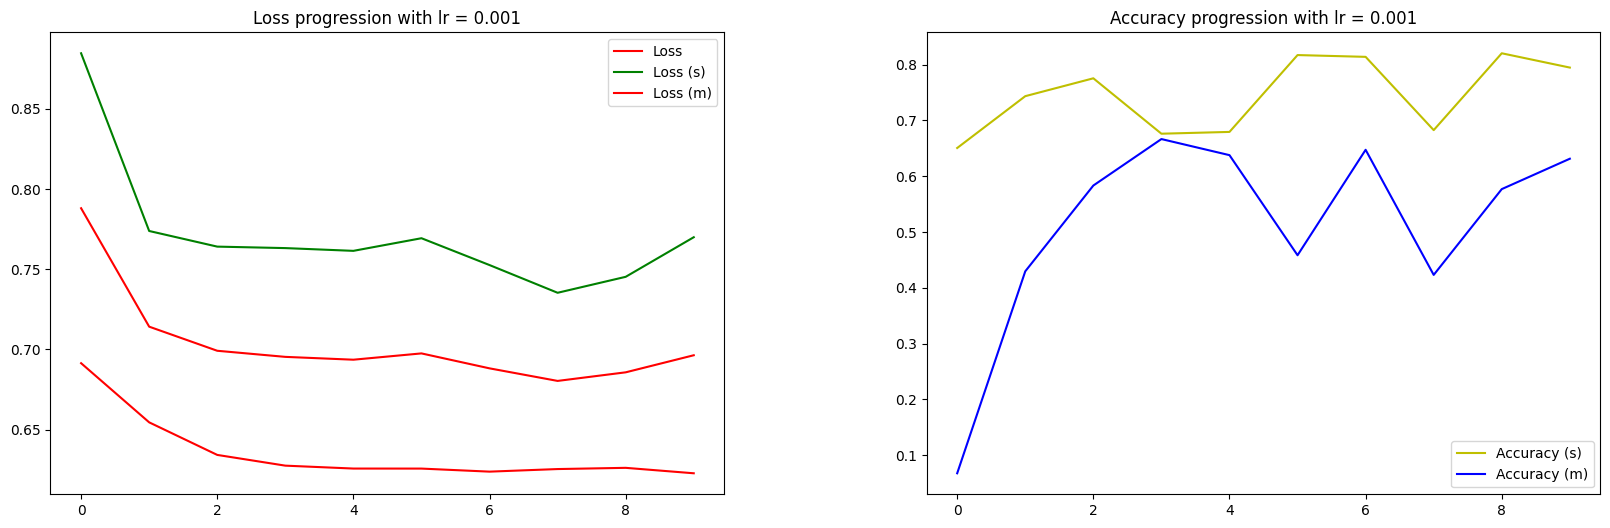

In [275]:
plot_results(accs_s, accs_m, losses, single_losses, multi_losses)

# Learning rate = 0.01

In [298]:
model_mt = MultiTaskModel().to(device)
optimizer_single = optim.Adam(filter(lambda p: p.requires_grad, model_mt.parameters()), lr=0.01)
optimizer_multi = optim.Adam(filter(lambda p: p.requires_grad, model_mt.parameters()), lr=0.01)

criterion_multi = nn.BCEWithLogitsLoss().to(device)
criterion_single = nn.CrossEntropyLoss().to(device)

In [299]:
multi_losses, accs_m = train_multi_label(model_mt, 10)

[epoch 1]: loss: 0.694, single acc: 0.394, multi acc: 0.000, duration: 45s
[epoch 2]: loss: 0.693, single acc: 0.404, multi acc: 0.000, duration: 41s
[epoch 3]: loss: 0.693, single acc: 0.391, multi acc: 0.000, duration: 41s
[epoch 4]: loss: 0.693, single acc: 0.410, multi acc: 0.000, duration: 41s
[epoch 5]: loss: 0.693, single acc: 0.381, multi acc: 0.000, duration: 41s
[epoch 6]: loss: 0.693, single acc: 0.369, multi acc: 0.000, duration: 44s
[epoch 7]: loss: 0.693, single acc: 0.375, multi acc: 0.000, duration: 43s
[epoch 8]: loss: 0.693, single acc: 0.381, multi acc: 0.000, duration: 43s
[epoch 9]: loss: 0.693, single acc: 0.378, multi acc: 0.000, duration: 50s
[epoch 10]: loss: 0.693, single acc: 0.378, multi acc: 0.000, duration: 41s


In [300]:
single_losses, accs_s = train_single_label(model_mt, 10)

[epoch 1]: loss: 1.079, single acc: 0.333, multi acc: 0.000, duration: 32s
[epoch 2]: loss: 1.077, single acc: 0.333, multi acc: 0.000, duration: 33s
[epoch 3]: loss: 1.078, single acc: 0.333, multi acc: 0.000, duration: 33s
[epoch 4]: loss: 1.077, single acc: 0.333, multi acc: 0.000, duration: 33s
[epoch 5]: loss: 1.078, single acc: 0.333, multi acc: 0.000, duration: 33s
[epoch 6]: loss: 1.078, single acc: 0.333, multi acc: 0.000, duration: 33s
[epoch 7]: loss: 1.077, single acc: 0.333, multi acc: 0.000, duration: 32s
[epoch 8]: loss: 1.079, single acc: 0.333, multi acc: 0.000, duration: 32s
[epoch 9]: loss: 1.078, single acc: 0.333, multi acc: 0.000, duration: 32s
[epoch 10]: loss: 1.077, single acc: 0.333, multi acc: 0.000, duration: 4522s


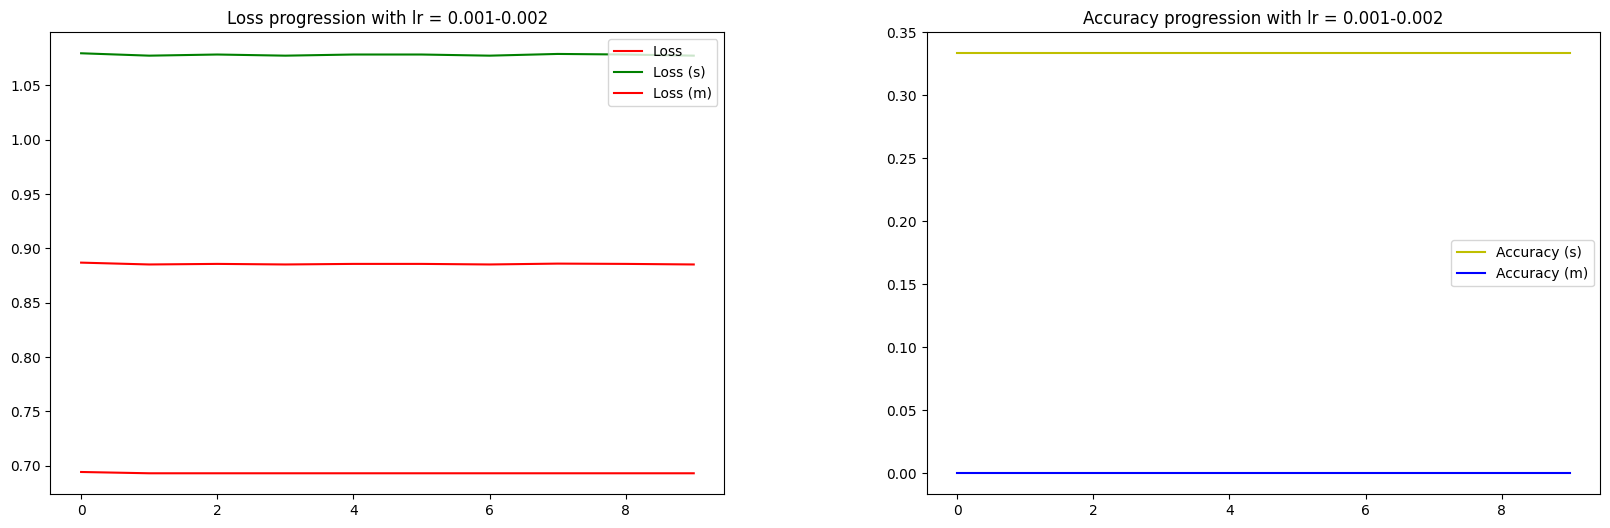

In [303]:
losses = (np.array(single_losses) + np.array(multi_losses)) / 2
plot_results(accs_s, accs_m, losses, single_losses, multi_losses)

# Learning rate = 0.002

In [304]:
model_mt = MultiTaskModel().to(device)
optimizer_single = optim.Adam(filter(lambda p: p.requires_grad, model_mt.parameters()), lr=0.002)
optimizer_multi = optim.Adam(filter(lambda p: p.requires_grad, model_mt.parameters()), lr=0.002)

criterion_multi = nn.BCEWithLogitsLoss().to(device)
criterion_single = nn.CrossEntropyLoss().to(device)

multi_losses_2, accs_m_2 = train_multi_label(model_mt, 10)
single_losses_2, accs_s_2 = train_single_label(model_mt, 10)

/Users/mantasbagdonas/miniconda3/envs/torch/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/mantasbagdonas/miniconda3/envs/torch/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[epoch 1]: loss: 0.694, single acc: 0.301, multi acc: 0.000, duration: 41s
[epoch 2]: loss: 0.693, single acc: 0.295, multi acc: 0.000, duration: 41s
[epoch 3]: loss: 0.694, single acc: 0.295, multi acc: 0.000, duration: 731s
[epoch 4]: loss: 0.693, single acc: 0.324, multi acc: 0.000, duration: 939s
[epoch 5]: loss: 0.693, single acc: 0.292, multi acc: 0.000, duration: 60s
[epoch 6]: loss: 0.693, single acc: 0.292, multi acc: 0.000, duration: 41s
[epoch 7]: loss: 0.693, single acc: 0.314, multi acc: 0.000, duration: 42s


KeyboardInterrupt: 

In [ ]:
losses = (np.array(single_losses_2) + np.array(multi_losses_2)) / 2
plot_results(accs_s_2, accs_m_2, losses, single_losses_2, multi_losses_2)

# Learning rate = 0.005

In [ ]:
model_mt = MultiTaskModel().to(device)
optimizer_single = optim.Adam(filter(lambda p: p.requires_grad, model_mt.parameters()), lr=0.002)
optimizer_multi = optim.Adam(filter(lambda p: p.requires_grad, model_mt.parameters()), lr=0.002)

criterion_multi = nn.BCEWithLogitsLoss().to(device)
criterion_single = nn.CrossEntropyLoss().to(device)

multi_losses_2, accs_m_2 = train_multi_label(model_mt, 10)
single_losses_2, accs_s_2 = train_single_label(model_mt, 10)

In [ ]:
losses = (np.array(single_losses_2) + np.array(multi_losses_2)) / 2
plot_results(accs_s_2, accs_m_2, losses, single_losses_2, multi_losses_2)

# Learning rate = 0.0005

In [ ]:
model_mt = MultiTaskModel().to(device)
optimizer_single = optim.Adam(filter(lambda p: p.requires_grad, model_mt.parameters()), lr=0.0005)
optimizer_multi = optim.Adam(filter(lambda p: p.requires_grad, model_mt.parameters()), lr=0.0005)

criterion_multi = nn.BCEWithLogitsLoss().to(device)
criterion_single = nn.CrossEntropyLoss().to(device)

multi_losses_2, accs_m_2 = train_multi_label(model_mt, 10)
single_losses_2, accs_s_2 = train_single_label(model_mt, 10)

In [ ]:
losses = (np.array(single_losses_2) + np.array(multi_losses_2)) / 2
plot_results(accs_s_2, accs_m_2, losses, single_losses_2, multi_losses_2)

## Testing out different learning rates with SGD optimizer

In [ ]:
def plot_results():
    fig, axs = plt.subplots(len(lrs), 2, figsize=(20, 20))

    for i in range(len(model_arr)):
        losses = (np.array(all_losses_s[i]) + np.array(all_losses_m[i])) / 2
        axs[i][0].plot(all_losses[i], c="b", label="Loss")
        axs[i][0].plot(all_losses_s[i], c="g", label="Loss (s)")
        axs[i][0].plot(all_losses_m[i], c="r", label="Loss (m)")
        axs[i][1].plot(all_accs[i][0], c="y", label="Accuracy (s)")
        axs[i][1].plot(all_accs[i][1], c="b", label="Accuracy (m)")
        axs[i][0].set_title('Loss progression with lr = ' + str(lrs[i]))
        axs[i][1].set_title('Accuracy progression with lr = ' + str(lrs[i]))
        axs[i][0].legend()
        axs[i][1].legend()

    fig.subplots_adjust(wspace=0.3)
    plt.show()

In [277]:
version = "10.0"

In [295]:
lrs = [0.01, 0.002, 0.005, 0.0005]

all_losses = []
all_losses_s = []
all_losses_m = []
all_accs = []
model_arr = []
for i in range(len(lrs)):
    print("Training model with learning rate:", lrs[i])
    new_model = MultiTaskModel().to(device)
    
    optimizer_single = optim.Adam(filter(lambda p: p.requires_grad, new_model.parameters()), lr=lrs[i])
    optimizer_multi = optim.Adam(filter(lambda p: p.requires_grad, new_model.parameters()), lr=lrs[i])

    criterion_multi = nn.BCEWithLogitsLoss().to(device)
    criterion_single = nn.CrossEntropyLoss().to(device)
    
    losses_s, accs_s = train_single_label(new_model, 5)
    losses_m, accs_m = train_multi_label(new_model, 5)
    
    accs = [(accs_s[i][0], accs_m[i][1]) for i in range(len(accs_m))]
    losses = (np.array(losses_s) + np.array(losses_m)) / 2
    
    torch.save(new_model.state_dict(), 'model-adam' + str(lrs[i]) + '-' + version + '.pth')
    model_arr.append(new_model)
    all_accs.append(accs)
    all_losses.append(losses)
    all_losses_s.append(losses_s)
    all_losses_m.append(losses_m)
    

Training model with learning rate: 0.01


/Users/mantasbagdonas/miniconda3/envs/torch/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/mantasbagdonas/miniconda3/envs/torch/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[epoch 1]: loss: 1.079, single acc: 0.333, multi acc: 0.000, duration: 32s


KeyboardInterrupt: 

In [ ]:
plot_results()

## Testing out different learning rates with Adam optimizer

In [ ]:
lrs = [0.01, 0.005, 0.0005]

all_losses = []
all_losses_s = []
all_losses_m = []
all_accs = []
model_arr = []
for i in range(len(lrs)):
    new_model = MultiTaskModel().to(device)
    optimizer = optim.Adam(new_model.parameters(), lr=lrs[i])
    losses_m, accs = train_multi_label(new_model, optimizer, 5)
    
    optimizer = optim.Adam(new_model.parameters(), lr=lrs[i])
    losses_m, accs = train_single_label(new_model, optimizer, 5)
    
    torch.save(new_model.state_dict(), 'model-adam' + lrs[i] + '-' + version +  '.pth')
    model_arr.append(new_model)
    all_accs.append(accs)
    all_losses.append(losses)
    all_losses_s.append(losses_s)
    all_losses_m.append(losses_m)
    

In [ ]:
plot_results()

In [ ]:
def plot_img(file):
    img = read_img(file, False)
    rgb_img = img.permute(1, 2, 0)
    fig, ax = plt.subplots()
    img = ax.imshow(rgb_img)

In [ ]:
fig, ax = plt.subplots(2, 3, figsize=(12,8))
X_test, Y_test = get_data('test')

for i in range(2):
    for j in range(3):
        x = read_img(X_test[i + j], True, True)
        predict = model(x)
#         p = predict[0].detach().numpy()[0]
#         print(p)
        img = read_img(X_test[i + j], False)
        rgb_img = img.permute(1, 2, 0)
        
        ax[i,j].imshow(rgb_img)
        ax[i,j].set_title('actual: ' + classes[Y_true[i]] + ' predicted: ' + classes[np.argmax(p)])
        #single label prediction


## Fake Multitask

In [23]:
class FakeMultiTaskModel(nn.Module):
    def __init__(self):
        super(FakeMultiTaskModel, self).__init__()
        self.model = models.resnet18(pretrained=True)
        
        self.features = nn.Sequential(*list(self.model.children())[:-1])
        
        self.model.fc_multi = nn.Sequential(nn.Flatten(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 3),
            nn.Sigmoid())
        
        for param in self.model.parameters():
            self.model.requires_grad = False
        self.model.fc_multi.requires_grad = True
        
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)

        return self.model.fc_multi(x)

In [24]:
model3 = FakeMultiTaskModel()
criterion = nn.BCEWithLogitLoss()
optimizer_sgd = optim.SGD(model3.parameters(), lr=0.001, momentum=0.9)

In [32]:
losses = train_model(criterion, model3, optimizer_sgd, 10)
torch.save(model3.state_dict(), 'wrapped-model-sgd0.001-1.0.0.pth')

[1,   100] loss: 0.997
[1,   200] loss: 0.786
[1,   300] loss: 0.701
[2,   100] loss: 0.667
[2,   200] loss: 0.663
[2,   300] loss: 0.651
[3,   100] loss: 0.636
[3,   200] loss: 0.635
[3,   300] loss: 0.636
[4,   100] loss: 0.619
[4,   200] loss: 0.623
[4,   300] loss: 0.625
[5,   100] loss: 0.606
[5,   200] loss: 0.605
[5,   300] loss: 0.606
[6,   100] loss: 0.599
[6,   200] loss: 0.587
[6,   300] loss: 0.588
[7,   100] loss: 0.585
[7,   200] loss: 0.584
[7,   300] loss: 0.593
[8,   100] loss: 0.578
[8,   200] loss: 0.582
[8,   300] loss: 0.582
[9,   100] loss: 0.581
[9,   200] loss: 0.584
[9,   300] loss: 0.580
[10,   100] loss: 0.572
[10,   200] loss: 0.574
[10,   300] loss: 0.577


In [37]:
evaluate_standalone(model3)

              precision    recall  f1-score   support

      Flower       0.62      1.00      0.76       104
         Dog       0.95      0.58      0.72       104
         Cat       0.85      0.65      0.74       104

    accuracy                           0.74       312
   macro avg       0.81      0.74      0.74       312
weighted avg       0.81      0.74      0.74       312



In [196]:
model_mt = MultiTaskModel().to(device)

In [199]:
weights = torch.load('multi_task_single_label_frozen-3.0.pth')

In [200]:
model_mt.load_weights(weights)

<All keys matched successfully>

In [201]:
evaluate_model(model_mt)

Single-label
              precision    recall  f1-score   support

      Flower       0.37      0.35      0.36       104
         Dog       0.00      0.00      0.00       104
         Cat       0.36      0.73      0.48       104

    accuracy                           0.36       312
   macro avg       0.24      0.36      0.28       312
weighted avg       0.24      0.36      0.28       312


Multi-label
              precision    recall  f1-score   support

      Flower       0.45      0.24      0.31       104
         Dog       0.33      1.00      0.50       104
         Cat       0.33      1.00      0.50       104

   micro avg       0.34      0.75      0.47       312
   macro avg       0.37      0.75      0.44       312
weighted avg       0.37      0.75      0.44       312
 samples avg       0.34      0.75      0.47       312



In [219]:
model_main = MultiTaskModel().to(device)

In [221]:
weights2 = torch.load('multi_task_multi_label_freezed-3.0.pth')
model_main.load_state_dict(weights2)

RuntimeError: Error(s) in loading state_dict for MultiTaskModel:
	size mismatch for model.fc_multi.1.weight: copying a param with shape torch.Size([128, 512]) from checkpoint, the shape in current model is torch.Size([512, 512]).
	size mismatch for model.fc_multi.1.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for model.fc_multi.4.weight: copying a param with shape torch.Size([3, 128]) from checkpoint, the shape in current model is torch.Size([3, 512]).

In [212]:
evaluate_model(model_main)

Single-label
              precision    recall  f1-score   support

      Flower       0.00      0.00      0.00       104
         Dog       0.33      0.65      0.44       104
         Cat       0.34      0.35      0.34       104

    accuracy                           0.33       312
   macro avg       0.22      0.33      0.26       312
weighted avg       0.22      0.33      0.26       312


Multi-label
              precision    recall  f1-score   support

      Flower       0.40      0.02      0.04       104
         Dog       0.23      0.03      0.05       104
         Cat       0.33      0.37      0.35       104

   micro avg       0.33      0.14      0.19       312
   macro avg       0.32      0.14      0.15       312
weighted avg       0.32      0.14      0.15       312
 samples avg       0.12      0.14      0.13       312

